In [2]:
import wandb

wandb.init(project="house-price-regression", name="final_run")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nurch22 (nurch22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
! pip install kaggle


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! mkdir ~/.kaggle

In [6]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 630MB/s]


In [9]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [10]:
!pip install autogluon.timeseries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

from typing import List
from tqdm.auto import tqdm

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.metrics.abstract import TimeSeriesScorer
from autogluon.timeseries.metrics import TimeSeriesScorer

import warnings

In [12]:

train = pd.read_csv("/content/train.csv.zip")
test = pd.read_csv("/content/test.csv.zip")
stores = pd.read_csv("/content/stores.csv")
features = pd.read_csv("/content/features.csv.zip")
sub = pd.read_csv("/content/sampleSubmission.csv.zip")

In [13]:


markdown_cols_to_drop = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',"CPI", "Unemployment"]
features = features.drop(columns=markdown_cols_to_drop)

train_merged = pd.merge(train, stores, on='Store', how='left')
test_merged = pd.merge(test, stores, on='Store', how='left')

trainy = pd.merge(train_merged, features, on=['Store', 'Date',"IsHoliday"], how='left')
testy = pd.merge(test_merged, features, on=['Store', 'Date',"IsHoliday"], how='left')

trainy['Date'] = pd.to_datetime(trainy['Date'])
testy['Date'] = pd.to_datetime(testy['Date'])



In [14]:


total_sales = trainy.groupby('Date')['Weekly_Sales'].sum()



In [15]:
total_sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [16]:
# 2. Apply ADFuller Test
print("--- Augmented Dickey-Fuller (ADFuller) Test Results ---")
adfuller_result = adfuller(total_sales)
adfuller_output = pd.Series(adfuller_result[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in adfuller_result[4].items():
    adfuller_output[f'Critical Value ({key})'] = value
print(adfuller_output)
print("\n")

# 3. Apply KPSS Test
print("--- KPSS Test Results ---")
kpss_result = kpss(total_sales, regression='c', nlags="auto")
kpss_output = pd.Series(kpss_result[0:3], index=['Test Statistic', 'p-value', '# Lags Used'])
for key, value in kpss_result[3].items():
    kpss_output[f'Critical Value ({key})'] = value
print(kpss_output)

--- Augmented Dickey-Fuller (ADFuller) Test Results ---
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
# Lags Used                    4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


--- KPSS Test Results ---
Test Statistic           0.048892
p-value                  0.100000
# Lags Used              5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipython-input-16-956798076.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(total_sales, regression='c', nlags="auto")


In [17]:
df = trainy.copy()
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

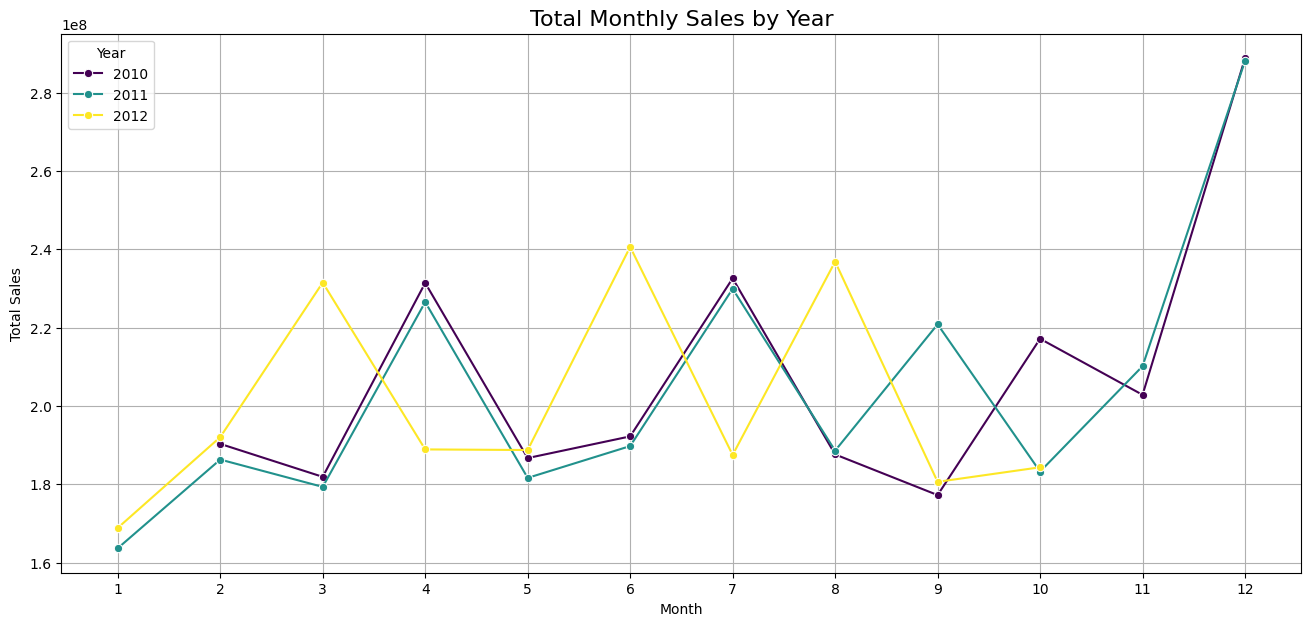

In [18]:
fig, ax1 = plt.subplots(figsize=(16, 7))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year',
             estimator='sum', errorbar=None, ax=ax1,
             palette='viridis', marker='o')

ax1.set_title('Total Monthly Sales by Year', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Sales')
ax1.set_xticks(range(1, 13))
ax1.grid(True)

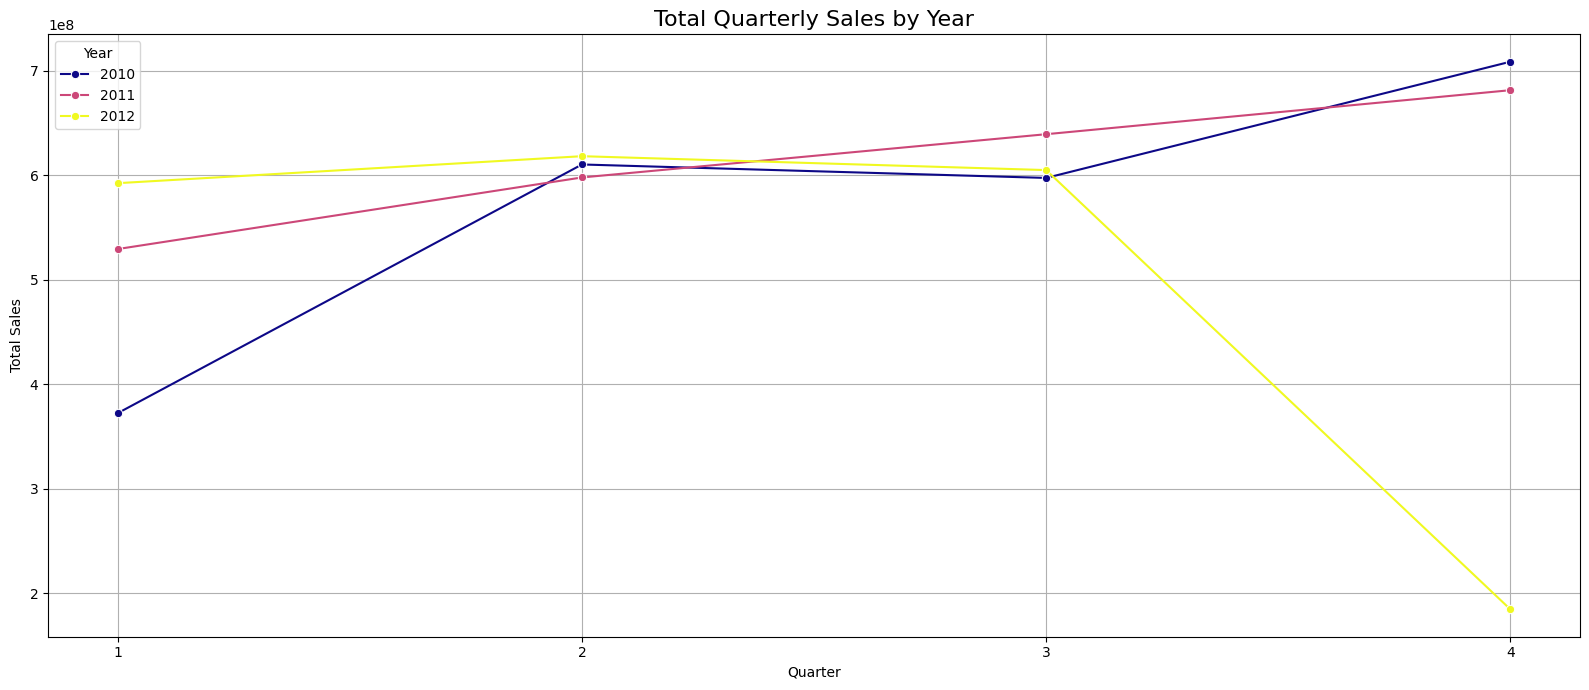

In [19]:
fig, ax2 = plt.subplots(figsize=(16, 7))
sns.lineplot(data=df, x='Quarter', y='Weekly_Sales', hue='Year',
             estimator='sum', errorbar=None, ax=ax2,
             palette='plasma', marker='o')

ax2.set_title('Total Quarterly Sales by Year', fontsize=16)
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Total Sales')
ax2.set_xticks(range(1, 5)) # Show quarters 1 to 4 on the x-axis
ax2.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipython-input-20-4288828864.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(total_sales.resample('M').sum(), ax=ax1)


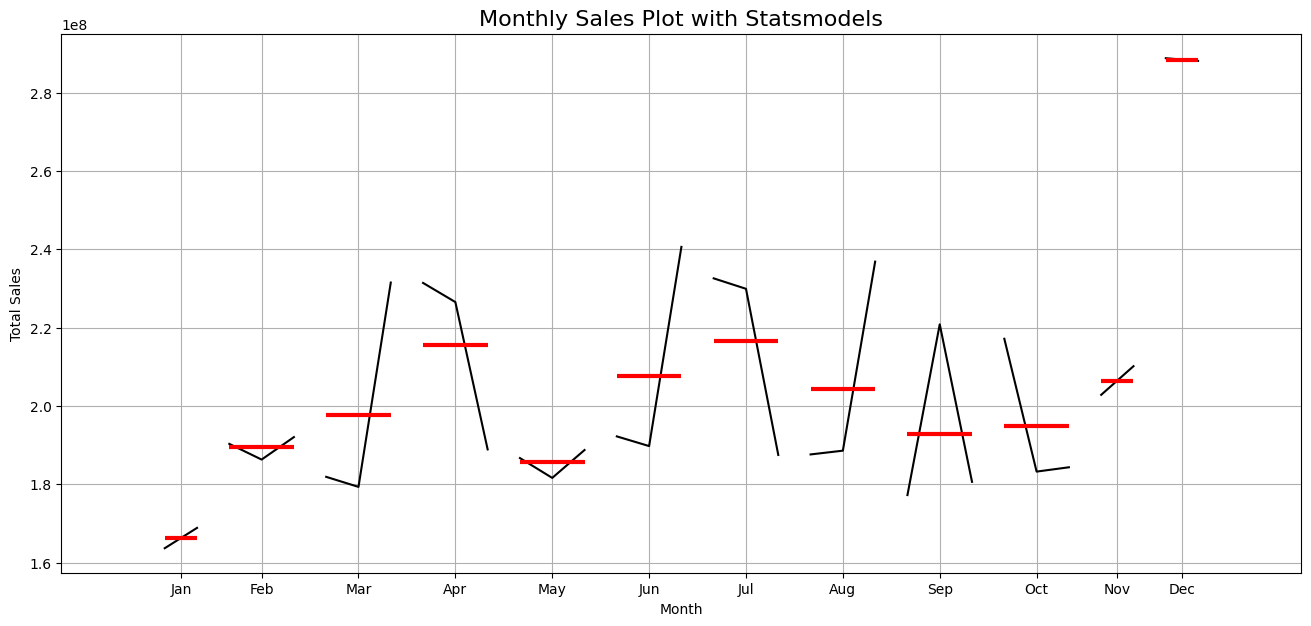

In [20]:
fig, ax1 = plt.subplots(figsize=(16, 7))
month_plot(total_sales.resample('M').sum(), ax=ax1)
ax1.set_title('Monthly Sales Plot with Statsmodels', fontsize=16)
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Sales')
ax1.grid(True)

/tmp/ipython-input-21-369528085.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(total_sales.resample('Q').sum(), ax=ax2)


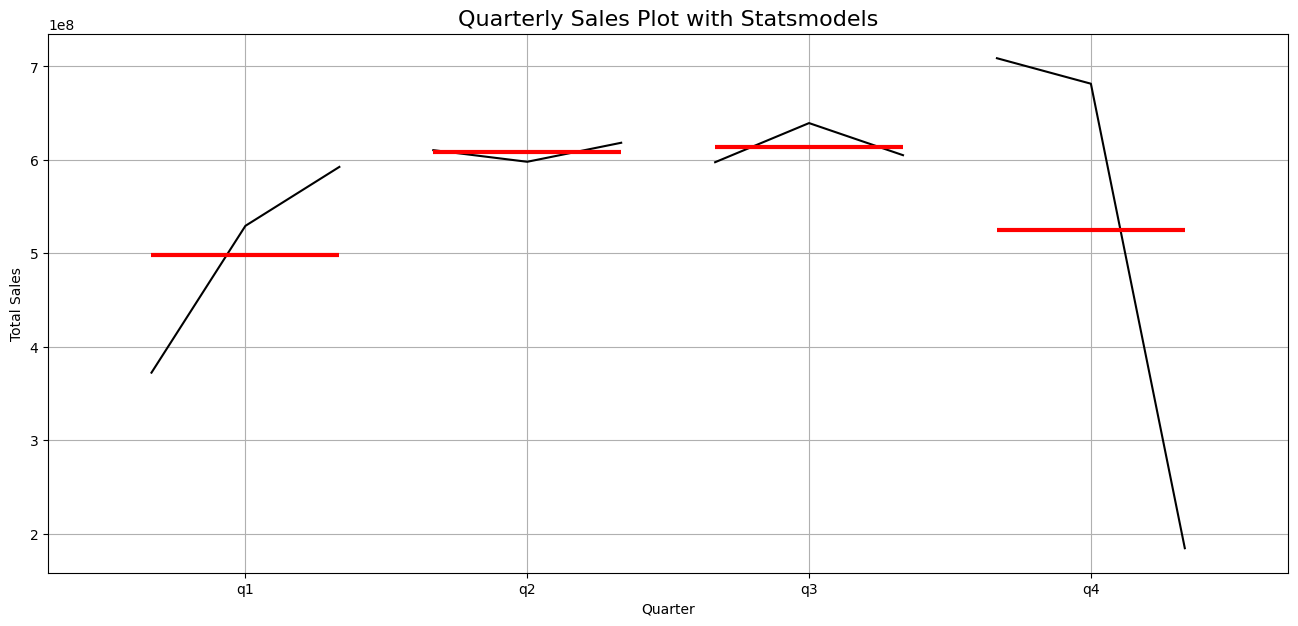

In [21]:
fig, ax2 = plt.subplots(figsize=(16, 7))
quarter_plot(total_sales.resample('Q').sum(), ax=ax2)
ax2.set_title('Quarterly Sales Plot with Statsmodels', fontsize=16)
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Total Sales')
ax2.grid(True)

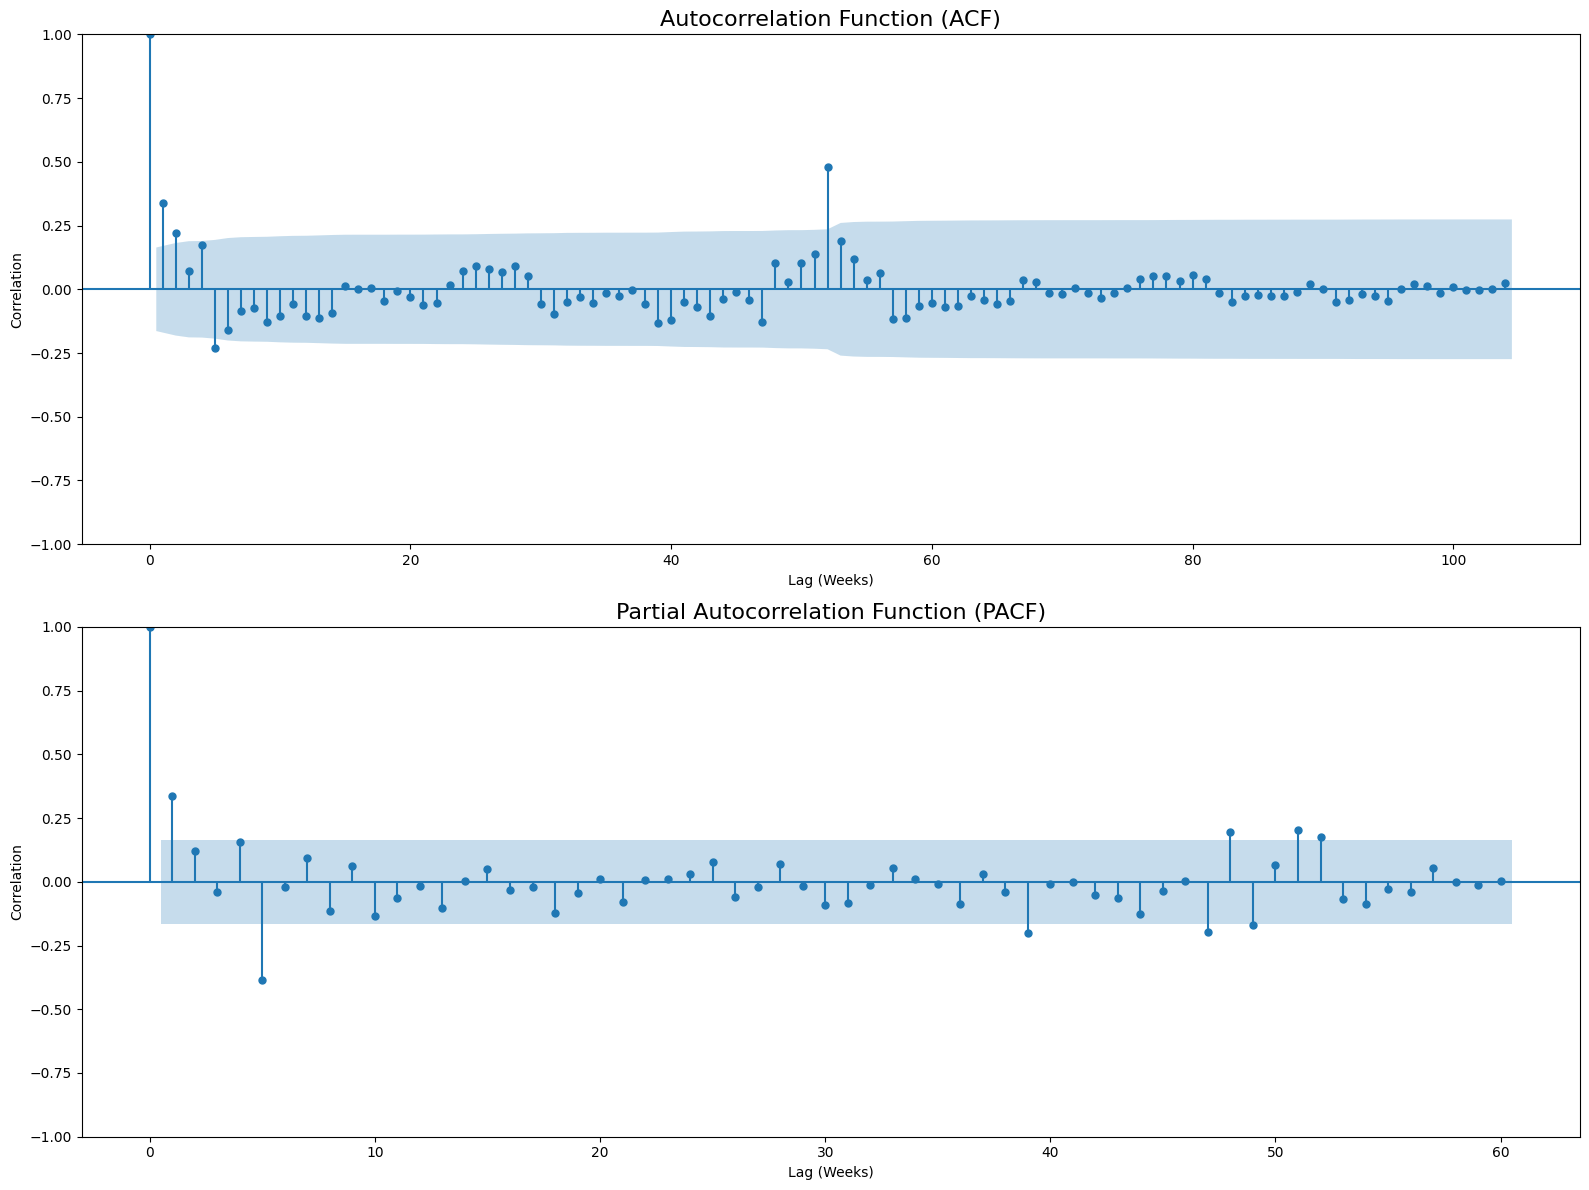

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# ACF Plot
plot_acf(total_sales, lags=104, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)', fontsize=16)
ax1.set_xlabel('Lag (Weeks)')
ax1.set_ylabel('Correlation')

# PACF Plot
plot_pacf(total_sales, lags=60, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function (PACF)', fontsize=16)
ax2.set_xlabel('Lag (Weeks)')
ax2.set_ylabel('Correlation')

plt.tight_layout()
plt.show()


In [23]:
SUPER_BOWL_DATES = pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'])
LABOR_DAY_DATES = pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'])
THANKSGIVING_DATES = pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'])
CHRISTMAS_DATES = pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'])

HOLIDAY_MAPPING = {
    'Super_Bowl': SUPER_BOWL_DATES,
    'Labor_Day': LABOR_DAY_DATES,
    'Thanksgiving': THANKSGIVING_DATES,
    'Christmas': CHRISTMAS_DATES
}


# --- 2. Enhanced Feature Engineering Functions ---

def create_time_features(df: pd.DataFrame, date_col: str = 'Date') -> pd.DataFrame:
    """
    Derives time-based features from a date column in the given DataFrame.
    """
    df_copy = df.copy()
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])

    df_copy['Year'] = df_copy[date_col].dt.year
    df_copy['Month'] = df_copy[date_col].dt.month
    df_copy['WeekOfYear'] = df_copy[date_col].dt.isocalendar().week.astype(int)
    df_copy['DayOfMonth'] = df_copy[date_col].dt.day
    df_copy['DayOfWeek'] = df_copy[date_col].dt.dayofweek  # Monday=0, Sunday=6
    df_copy['DayOfYear'] = df_copy[date_col].dt.dayofyear
    df_copy['Quarter'] = df_copy[date_col].dt.quarter
    # Approximates the week of the month
    df_copy['WeekOfMonth'] = (df_copy[date_col].dt.day - 1) // 7 + 1

    return df_copy

def add_holiday_features(df: pd.DataFrame, date_col: str = 'Date') -> pd.DataFrame:
    """
    Adds only the holiday type feature to the DataFrame. The 'IsHoliday' column has been removed.
    """
    df_copy = df.copy()
    df_copy['HolidayType'] = 'Normal_Day'

    for holiday_name, holiday_dates in HOLIDAY_MAPPING.items():
        df_copy.loc[df_copy[date_col].isin(holiday_dates), 'HolidayType'] = holiday_name

    # The line that created the 'IsHoliday' column has been removed.

    return df_copy

def add_holiday_proximity_features(df: pd.DataFrame, group_cols: List[str], date_col: str = 'Date') -> pd.DataFrame:
    """
    Calculates how many days are left until the next holiday and how many days have passed
    since the previous holiday for each day. It now uses the 'HolidayType' column instead of 'IsHoliday'.
    """
    df_copy = df.copy()
    # The data must be sorted for this function to work correctly.
    df_copy = df_copy.sort_values(by=group_cols + [date_col])

    def calculate_proximity(group):
        # We determine holiday dates based on 'HolidayType' instead of 'IsHoliday'.
        group_holiday_dates = group[group['HolidayType'] != 'Normal_Day'][date_col]
        if not group_holiday_dates.empty:
            date_values = group[date_col].values
            holiday_values = group_holiday_dates.values

            diff_matrix = (date_values[:, None] - holiday_values).astype('timedelta64[D]').astype(int)

            future_diffs = np.where(diff_matrix <= 0, diff_matrix, -np.inf)
            group['Days_Until_Next_Holiday'] = np.max(future_diffs, axis=1) * -1
            group['Days_Until_Next_Holiday'].replace([np.inf, -np.inf], np.nan, inplace=True)

            past_diffs = np.where(diff_matrix >= 0, diff_matrix, np.inf)
            group['Days_Since_Last_Holiday'] = np.min(past_diffs, axis=1)
            group['Days_Since_Last_Holiday'].replace([np.inf, -np.inf], np.nan, inplace=True)
        else:
            group['Days_Until_Next_Holiday'] = np.nan
            group['Days_Since_Last_Holiday'] = np.nan
        return group

    df_copy = df_copy.groupby(group_cols, group_keys=False).apply(calculate_proximity)

    # 'HolidayType' is used to set the day counter to 0 on holidays.
    df_copy.loc[df_copy['HolidayType'] != 'Normal_Day', ['Days_Until_Next_Holiday', 'Days_Since_Last_Holiday']] = 0
    return df_copy


def add_lag_features(df: pd.DataFrame, group_cols: List[str], cols_to_lag: List[str], lags: List[int]) -> pd.DataFrame:
    """
    Adds lag features for the specified columns.
    """
    df_copy = df.copy()
    df_copy = df_copy.sort_values(by=group_cols + ['Date'])

    for col in cols_to_lag:
        if col in df_copy.columns:
            for lag in lags:
                new_col_name = f'{col}_lag_{lag}'
                df_copy[new_col_name] = df_copy.groupby(group_cols)[col].shift(lag)
        else:
            print(f"Warning: Column '{col}' for lag not found. Skipping.")
    return df_copy


def create_cyclical_features(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    Represents cyclical features (e.g., DayOfWeek, Month) with sine and cosine transformations.
    """
    df_copy = df.copy()
    feature_map = {
        'DayOfWeek': 6, 'Month': 12, 'DayOfMonth': 31,
        'WeekOfYear': 52, 'DayOfYear': 366, 'Quarter': 4
    }
    for feature in features:
        if feature in df_copy.columns and feature in feature_map:
            max_val = feature_map[feature]
            values = df_copy[feature]
            if feature == 'Month':
                values = values - 1
            df_copy[f'{feature}_sin'] = np.sin(2 * np.pi * values / (max_val + (1 if feature != 'Month' else 0)))
            df_copy[f'{feature}_cos'] = np.cos(2 * np.pi * values / (max_val + (1 if feature != 'Month' else 0)))
        else:
            print(f"Warning: Column '{feature}' for cyclical feature not found or not mapped. Skipping.")
    return df_copy


# --- 3. Main Feature Engineering Pipeline Function ---

def feature_engineer(df: pd.DataFrame, group_cols: List[str]) -> pd.DataFrame:
    """
    Applies all feature engineering steps to a given dataframe.
    This function no longer creates target-dependent features.
    """
    print("Starting feature engineering...")

    # Step 1: Create basic time features
    df_featured = create_time_features(df)

    # Step 2: Add holiday features (without 'IsHoliday')
    df_featured = add_holiday_features(df_featured)
    df_featured = add_holiday_proximity_features(df_featured, group_cols=group_cols)

    # Step 3: Create cyclical features
    cyclical_cols = ['DayOfWeek', 'Month', 'WeekOfYear', 'DayOfYear']
    df_featured = create_cyclical_features(df_featured, features=cyclical_cols)

    # Step 4: Lag features (Only for common covariates)
    cols_to_lag = ['Temperature', 'Fuel_Price']
    df_featured = add_lag_features(df_featured, group_cols=group_cols, cols_to_lag=cols_to_lag, lags=[7, 14, 28])

    # Step 5: One-hot encoding for categorical features
    # This step is now performed on the combined data, ensuring consistency.
    df_featured = pd.get_dummies(df_featured, columns=['Type', 'HolidayType'], drop_first=True)

    # Step 6: Fill NaN values
    for col in df_featured.columns:
        if df_featured[col].isnull().any():
            df_featured[col] = df_featured.groupby(group_cols)[col].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
            df_featured[col] = df_featured[col].fillna(0)

    print("Feature engineering complete.")
    return df_featured

In [24]:


GROUP_COLS = ['Store', 'Dept']
TARGET_COL = 'Weekly_Sales'

train_target = trainy[TARGET_COL]
train_features = trainy.drop(columns=[TARGET_COL])

train_features['origin'] = 'train'
testy['origin'] = 'test'

combined_df = pd.concat([train_features, testy], ignore_index=True)
combined_featured = feature_engineer(combined_df, group_cols=GROUP_COLS)

train_final = combined_featured[combined_featured['origin'] == 'train'].drop(columns=['origin'])
test_final = combined_featured[combined_featured['origin'] == 'test'].drop(columns=['origin'])

train_final[TARGET_COL] = train_target



Starting feature engineering...


Streaming output truncated to the last 5000 lines.
For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  group['Days_Since_Last_Holiday'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-23-3469043303.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  group['Days_Until_Next_Holiday'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-

Feature engineering complete.


In [25]:


print("\n--- Processed Training Data Columns ---")
print(train_final.columns)
print(f"Number of training data columns: {len(train_final.columns)}")

print("\n--- Processed Test Data Columns ---")
print(test_final.columns)
print(f"Number of test data columns: {len(test_final.columns)}")

# Check if columns (excluding the target) are consistent
feature_cols_train = set(train_final.drop(columns=[TARGET_COL]).columns)
feature_cols_test = set(test_final.columns)

print(f"\nAre the feature columns the same? {feature_cols_train == feature_cols_test}")




--- Processed Training Data Columns ---
Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Size', 'Temperature',
       'Fuel_Price', 'Year', 'Month', 'WeekOfYear', 'DayOfMonth', 'DayOfWeek',
       'DayOfYear', 'Quarter', 'WeekOfMonth', 'Days_Until_Next_Holiday',
       'Days_Since_Last_Holiday', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'Month_sin', 'Month_cos', 'WeekOfYear_sin', 'WeekOfYear_cos',
       'DayOfYear_sin', 'DayOfYear_cos', 'Temperature_lag_7',
       'Temperature_lag_14', 'Temperature_lag_28', 'Fuel_Price_lag_7',
       'Fuel_Price_lag_14', 'Fuel_Price_lag_28', 'Type_B', 'Type_C',
       'HolidayType_Labor_Day', 'HolidayType_Normal_Day',
       'HolidayType_Super_Bowl', 'HolidayType_Thanksgiving', 'Weekly_Sales'],
      dtype='object')
Number of training data columns: 38

--- Processed Test Data Columns ---
Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Size', 'Temperature',
       'Fuel_Price', 'Year', 'Month', 'WeekOfYear', 'DayOfMonth', 'DayOfWeek',
       'DayOfYear', 'Q

In [26]:


train_final['item_id'] = train_final['Store'].astype(str) + '_' + train_final['Dept'].astype(str)
test_final['item_id'] = test_final['Store'].astype(str) + '_' + test_final['Dept'].astype(str)

train_data = TimeSeriesDataFrame.from_data_frame(
    train_final,
    id_column="item_id",
    timestamp_column="Date"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    test_final,
    id_column="item_id",
    timestamp_column="Date"
)



In [27]:
is_holiday = trainy[["Date","IsHoliday"]].drop_duplicates(subset=["Date","IsHoliday"]).set_index("Date").to_dict()["IsHoliday"]

In [28]:
class weighted_mean_absolute_error(TimeSeriesScorer):
    greater_is_better_internal = False
    optimum = 0.0

    def custom_wmae(self, y_true, y_pred):
        weight = np.where(y_true.index.get_level_values(1).map(is_holiday), 5 ,1)

        numerator=np.sum(weight * np.abs(y_true - y_pred))
        denominator = np.sum(weight)

        return numerator/denominator

    def compute_metric(self, data_future, predictions, target, **kwargs):
        return self.custom_wmae(y_true=data_future[target], y_pred=predictions["mean"])

In [29]:
unused_features_list = ['Year', 'Quarter', 'DayOfWeek_sin', 'Temperature_lag_14', 'Temperature_lag_28', 'Fuel_Price_lag_7', 'Temperature_lag_7', 'Fuel_Price_lag_14', 'Fuel_Price_lag_28']

train_data = train_data.drop(columns=unused_features_list)
test_data = test_data.drop(columns=unused_features_list)

feature_columns = list(test_data.columns)
known_covariates = [col for col in feature_columns if '_lag_' not in col and col != 'Date']

In [30]:
hyperparameters = {

    "Chronos":
            {'model_path': 'bolt_small',
             'fine_tune': True,
             'target_scaler': 'standard',
             "ag_args": {"name_suffix": "FineTuned"},
             'covariate_regressor': {'model_name': 'CAT',
                                     'model_hyperparameters':{'iterations': 1000}}},
    "DeepAR": {'target_scaler': 'standard'},

}

# Forecast Horizon
prediction_length = 39

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="autogluon_walmart_advanced",
    target="Weekly_Sales",
    eval_metric=weighted_mean_absolute_error(),
    known_covariates_names=known_covariates,
    quantile_levels=[0.1, 0.25, 0.45, 0.5, 0.55, 0.75, 0.9],
    freq="W-FRI"
)

In [31]:
predictor.fit(
    train_data,
    hyperparameters=hyperparameters,
    time_limit=1800,
    num_val_windows=2,
)

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to '/content/autogluon_walmart_advanced'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       10.19 GB / 12.67 GB (80.4%)
Disk Space Avail:   69.97 GB / 112.64 GB (62.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': weighted_mean_absolute_error,
 'freq': 'W-FRI',
 'hyperparameters': {'Chronos': {'ag_args': {'name_suffix': 'FineTuned'},
                                 'covariate_regressor': {'model_hyperparameters': {'iterations': 1000},
                                                         'model_name': 'CAT'},
                                 'fine_tune': True,
                                 'model_path': 'bolt_small',
                        

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Saving fine-tuned model to /content/autogluon_walmart_advanced/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Saving fine-tuned model to /content/autogluon_walmart_advanced/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	-2045.4044    = Validation score (-weighted_mean_absolute_error)
	329.16  s     = Training runtime
	1.72    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 811.7s of the 1411.7s of remaining time.
	-2752.0162    = Validation score (-weighted_mean_absolute_error)
	232.15  s     = Training runtime
	17.85   s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosFineTuned[bolt_small]': 0.95, 'DeepAR': 0.05}
	-2042.6089    = Validation score (-weighted_mean_absolute_error)
	13.92   s     = Training runtime
	19.56   s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosFineTuned[bolt_small]', 'DeepAR', 'WeightedEnsemble']
Total runtime: 

In [32]:
predictor.feature_importance(subsample_size=500)

Computing feature importance


,importance,stdev,n,p99_low,p99_high
Store,-0.132811,0.142220,5.0,-0.425645,0.160023
Dept,-0.123007,0.064498,5.0,-0.255809,0.009796
IsHoliday,1.707658,0.599810,5.0,0.472641,2.942675
Size,-0.199741,0.154226,5.0,-0.517293,0.117812
Temperature,81.982693,8.201591,5.0,65.095505,98.869881
Fuel_Price,35.179716,10.131848,5.0,14.318100,56.041331
Month,5.781003,3.383322,5.0,-1.185303,12.747309
WeekOfYear,61.431868,8.297475,5.0,44.347253,78.516484
DayOfMonth,48.003727,15.612415,5.0,15.857548,80.149905
DayOfWeek,-0.067473,0.157004,5.0,-0.390747,0.255801


In [33]:
predictor.leaderboard()
print("Best model: ", predictor.get_model_best())

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-2042.608945,19.564667,13.923247,3
1,ChronosFineTuned[bolt_small],-2045.404374,1.719305,329.160581,1
2,DeepAR,-2752.016178,17.845363,232.154481,2


In [34]:
test_item_counts = test_data.groupby(level=0).size()

valid_ids = test_item_counts[test_item_counts == prediction_length].index

same_ids = train_data.index.get_level_values(0).unique().intersection(valid_ids)

train_data_filtered = train_data.loc[same_ids]
test_data_filtered = test_data.loc[same_ids]

future_df = predictor.make_future_data_frame(train_data_filtered)
future_index = pd.MultiIndex.from_frame(future_df)

known_covariates_future = test_data_filtered.loc[test_data_filtered.index.isin(future_index)]

predictions = predictor.predict(
    train_data_filtered,
    known_covariates=known_covariates_future
)

data with frequency 'IRREG' has been resampled to frequency 'W-FRI'.
data with frequency 'IRREG' has been resampled to frequency 'W-FRI'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [35]:
submission_df = predictions.reset_index()
submission_df['Date_str'] = submission_df['timestamp'].dt.strftime('%Y-%m-%d')
submission_df['Id'] = submission_df['item_id'] + '_' + submission_df['Date_str']
submission_df = submission_df[['Id', 'mean']]
submission_df.rename(columns={'mean': 'Weekly_Sales'}, inplace=True)
submission_df['Weekly_Sales'] = submission_df['Weekly_Sales'].clip(lower=0)

submission_template = test_final[['Store', 'Dept', 'Date']].copy()
submission_template['Id'] = submission_template['Store'].astype(str) + '_' + submission_template['Dept'].astype(str) + '_' + submission_template['Date'].dt.strftime('%Y-%m-%d')

final_submission = pd.merge(submission_template[['Id']], submission_df, on='Id', how='left')
final_submission['Weekly_Sales'].fillna(0, inplace=True)

final_submission.to_csv('submission.csv', index=False)

In [39]:
# Log the model as an artifact
model_artifact = wandb.Artifact(
    "autogluon_walmart_advanced_model",
    type="model",
    description="AutoGluon TimeSeriesPredictor for Walmart Sales Forecasting"
)
model_artifact.add_dir("autogluon_walmart_advanced")
wandb.log_artifact(model_artifact)

wandb.finish()

wandb: Adding directory to artifact (./autogluon_walmart_advanced)... Done. 6.0s
